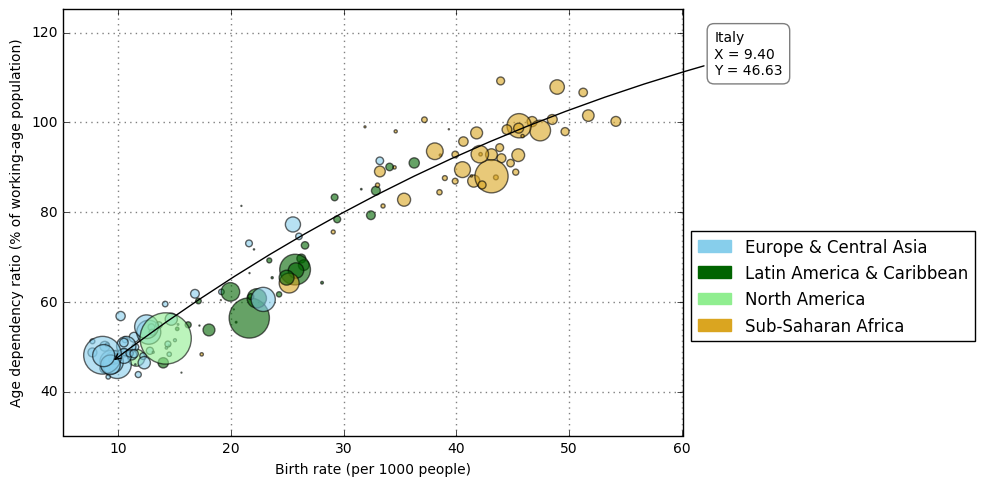

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display


#==============================#
#======== PREPARE DATA ========#
#==============================#

# read csv file
df = pd.read_csv('data.csv')

# convert stringy numbers to numbers
df[df.columns[4:]] = df[df.columns[4:]].apply(pd.to_numeric, errors='coerce')

# rename columns
df.columns = ['CountryName',
              'CountryCode',
              'SeriesName',
              'SeriesCode'] + ['Y'+str(i) for i in range(1960,2015)]

# rename some series for clarity
df.SeriesName = df.SeriesName.replace('Life expectancy at birth, total (years)',
                                      'Life expectancy at birth (years)')
df.SeriesName = df.SeriesName.replace('Birth rate, crude (per 1,000 people)',
                                      'Birth rate (per 1000 people)')
df.SeriesName = df.SeriesName.replace('Death rate, crude (per 1,000 people)',
                                      'Death rate (per 1000 people)')

# create abbreviated series name column (for toggle buttons)
df['SeriesName_short'] = df.SeriesName
df.SeriesName_short = df.SeriesName_short.replace('Age dependency ratio (% of working-age population)',
                                                  'Dependency ratio')
df.SeriesName_short = df.SeriesName_short.replace('Life expectancy at birth (years)',
                                                  'Life expectancy')
df.SeriesName_short = df.SeriesName_short.replace('Birth rate (per 1000 people)',
                                                  'Birth rate')
df.SeriesName_short = df.SeriesName_short.replace('Death rate (per 1000 people)',
                                                  'Death rate')
df.SeriesName_short = df.SeriesName_short.replace('Population, total',
                                                  'Population')
df.SeriesName_short = df.SeriesName_short.replace('Urban population (% of total)',
                                                  'Urban population')

# read csv file with region subdivision
df_regions = pd.read_csv('regions.csv', sep=';')

# rename columns
df_regions.columns = ['CountryName', 'Region']

# create region names list
RegionNames = list(sorted(set(df_regions['Region'])))

# choose colors (one per region, according to alphabetical order of regions)
MyColors = ['orangered',
            'skyblue',
            'darkgreen',
            'royalblue',
            'lightgreen',
            'darkred',
            'goldenrod']

# create color patches (for legend)
ColorPatches = [mpatches.Patch(color=MyColors[i],
                               label=RegionNames[i]) for i in range(len(MyColors))]

# create list of lists of countries (one list per region)
CountryLists = [list(df_regions[df_regions['Region'] == w]['CountryName']) for w in RegionNames]

# add additional "cross region" of top 20 most populous countries, as of 2014
RegionNames.append('Top 20 most populous')
CountryLists.append(list(df[df.SeriesName == 'Population, total'].sort_values('Y2014', ascending=False)['CountryName'][:20]))

# set colors to regions  
for i in range(len(MyColors)):
    df_regions.loc[df_regions['CountryName'].isin(CountryLists[i]), 'Color'] = MyColors[i]

# convert CountryLists to np.array (for later use) 
CountryLists = np.array(CountryLists)


#=================================#
#======== PREPARE WIDGETS ========#
#=================================#

# set layout for each single widget
items_layout = Layout(flex='1 1 auto', width='auto')

# set layout for each group of widgets
box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='space-around',
                    width='100%')

# collect abbreviated series-names (for toggle buttons)
opt = sorted(set(df.SeriesName_short.dropna()))
opt.remove('Population')

# create widgets and set initial values
XButtons = [Label(value='X ='),
            ToggleButtons(description=' ',
                          options=opt,
                          value=opt[0],
                          layout=items_layout)]
YButtons = [Label(value='Y ='),
            ToggleButtons(description=' ',
                          options=opt,
                          value=opt[1],
                          layout=items_layout)]
RegionButtons1 = [ToggleButton(description=r,
                               layout=items_layout)
                  for r in RegionNames[:4]]
RegionButtons2 = [ToggleButton(description=r,
                               layout=items_layout)
                  for r in RegionNames[4:]]
RegionButtons1[1].value = True
RegionButtons1[2].value = True
RegionButtons2[0].value = True
RegionButtons2[2].value = True
TimeSlider = IntSlider(description='Year',
                       min=1960,
                       max=2014,
                       value=1960,
                       continuous_update=False)
CountryPointer = Dropdown(description=' ',
                          options=CountryLists[1],
                          value='Italy')
PopulationCheckbox = Checkbox(description='Pop. size',
                              value=True)

# group widgets together
XBox = Box(XButtons,
           layout=box_layout)
YBox = Box(YButtons,
           layout=box_layout)
RegionBox1 = Box(children=RegionButtons1,
                 layout=box_layout)
RegionBox2 = Box(children=RegionButtons2,
                 layout=box_layout)
TimeAndCountrySelectors = Box(children=(TimeSlider,
                                        PopulationCheckbox,
                                        CountryPointer),
                              layout=box_layout)


#=========================================#
#======== CONNECT DATA TO WIDGETS ========#
#=========================================#

# plot data
def plot_chart(year):
    
    # get values from X and Y toggles
    SeriesName_x = getting_x.children[0].value
    SeriesName_y = getting_y.children[0].value
    
    # get values from region toggles
    r1 = getting_regions.children[0].value
    r2 = getting_regions.children[1].value
    r3 = getting_regions.children[2].value
    r4 = getting_regions.children[3].value
    r5 = getting_regions.children[4].value
    r6 = getting_regions.children[5].value
    r7 = getting_regions.children[6].value
    r8 = getting_regions.children[7].value
    
    # get value from population-size checkbox
    popsize = getting_popsize.children[0].value
    
    # create boolean array from region toggles
    SelectedRegions_bool = np.array([r1, r2, r3, r4, r5, r6, r7, r8])
    
    # flat all selected countries in one big list 
    SelectedCountries = sum(CountryLists[SelectedRegions_bool].tolist(), [])
    
    # if some region is selected: plot the data
    if SelectedCountries:
        
        # prepare x and y data for all years
        x = df[(df.SeriesName_short == SeriesName_x) & (df.CountryName.isin(SelectedCountries))].reset_index()
        y = df[(df.SeriesName_short == SeriesName_y) & (df.CountryName.isin(SelectedCountries))].reset_index()
        
        # prepare population size data for all years
        s = df[(df.SeriesName_short == 'Population') & (df.CountryName.isin(SelectedCountries))].reset_index()
        
        # prepare color values
        color_array = df_regions.loc[df_regions['CountryName'].isin(SelectedCountries), 'Color'].reset_index()
        
        # set limits for the chart (fixed in time)
        xmin = x[x.columns[4:]].min(axis=1).min(axis=0)
        xmax = x[x.columns[4:]].max(axis=1).max(axis=0)
        offset_x = (xmax-xmin)/20
        ymin = y[y.columns[4:]].min(axis=1).min(axis=0)
        ymax = y[y.columns[4:]].max(axis=1).max(axis=0)
        offset_y = (ymax-ymin)/20
        
        # evaluate data at selected year
        xx = x['Y'+str(year)]
        yy = y['Y'+str(year)]
        ss = (5e-6)*s['Y'+str(year)]
        
        # select values when both x and y are not NaN (for correct color assignment)
        xx = xx.where((x['Y'+str(year)].notnull()) & (y['Y'+str(year)].notnull()) & (s['Y'+str(year)].notnull())).dropna()
        yy = yy.where((x['Y'+str(year)].notnull()) & (y['Y'+str(year)].notnull()) & (s['Y'+str(year)].notnull())).dropna()
        ss = ss.where((x['Y'+str(year)].notnull()) & (y['Y'+str(year)].notnull()) & (s['Y'+str(year)].notnull())).dropna()
        color_array = color_array.where((x['Y'+str(year)].notnull()) & (y['Y'+str(year)].notnull()) & (s['Y'+str(year)].notnull())).dropna()
        
        # create axes with labels
        ax = plt.axes(xlim=(xmin-offset_x, xmax+offset_x),
                      ylim=(ymin-offset_y, ymax+offset_y),
                      xlabel=df.SeriesName[df.SeriesName_short == SeriesName_x].unique()[0],
                      ylabel=df.SeriesName[df.SeriesName_short == SeriesName_y].unique()[0])
        
        # create grid
        ax.grid(color='grey', linestyle=':', linewidth=1)
        
        # set figure size (please adjust it according to your browser)
        plt.gcf().set_size_inches((8, 5.5))
        
        # create scatter plot with or without population size
        if popsize:
            ax.scatter(xx,
                       yy,
                       s=ss,
                       alpha=0.6,
                       c=color_array['Color'],
                       edgecolor='black',
                       lw='1',
                       zorder=3)
        else:
            ax.scatter(xx,
                       yy,
                       s=30,
                       alpha=0.6,
                       c=color_array['Color'],
                       edgecolor='black',
                       lw='1',
                       zorder=3)            
        
        # create legend (distinguish when there is cross region of top 20 most populous countries)
        if ~SelectedRegions_bool[7]:
            ax.legend(handles=[ColorPatches[i] for i in np.array(list(range(8)))[SelectedRegions_bool]], loc='center left', bbox_to_anchor=(1, 0.35))
        else:
            ax.legend(handles=[ColorPatches[i] for i in range(7)], loc='center left', bbox_to_anchor=(1, 0.35))
        
        # warn if data are empty
        if xx.dropna().empty:
            annotation_string = r'Sorry, no data available :('
            annotation_string += '\n'
            annotation_string += r'Try another year or region!'            
            ax.text(xmin+(xmax-xmin)/2,
                    ymin+(ymax-ymin)/2,
                    annotation_string,
                    horizontalalignment='center',
                    verticalalignment='center',
                    bbox=dict(boxstyle='round,pad=0.5', fc='salmon', alpha=0.5))
        
        # get country name from dropdown menu
        country = getting_country.children[0].value
        
        # get country index
        country_index = x[x['CountryName'] == country].index
        
        # if a country is selected, write information if present (or warning sign if not)  
        if country_index.size > 0:
            if (np.isfinite(xx[country_index].values[0])) & (np.isfinite(yy[country_index].values[0])):
                annotation_string = r'{}'.format(country)
                annotation_string += '\n'
                annotation_string += r'X = {:.2f}'.format(xx[country_index].values[0])
                annotation_string += '\n'
                annotation_string += r'Y = {:.2f}'.format(yy[country_index].values[0])
                ax.annotate(annotation_string,
                            xy=(xx[country_index],
                            yy[country_index]),
                            xytext=(1.05,0.95),
                            textcoords='axes fraction',
                            ha='left',
                            va='top',
                            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
                            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0.1'))
            else:
                annotation_string = r'Sorry, no data available'
                annotation_string += '\n'
                annotation_string += r'for {}.'.format(country)
                annotation_string += '\n'
                annotation_string += r'Try another year or country!'            
                ax.text(xmax+offset_x+(xmax-xmin)/20,
                        ymax+offset_y-(ymax-ymin)/10,
                        annotation_string,
                        horizontalalignment='left',
                        verticalalignment='top',
                        bbox=dict(boxstyle='round,pad=0.5', fc='salmon', alpha=0.5))
    
    # if no region is selected: warning sign 
    else:
        ax = plt.axes(xlim=(0, 1),
                      ylim=(0, 1))
        annotation_string = r'Please select one'
        annotation_string += '\n'
        annotation_string += r'or more regions'            
        ax.text(0.5,
                0.5,
                annotation_string,
                horizontalalignment='center',
                verticalalignment='center',
                bbox=dict(boxstyle='round,pad=0.5', fc='salmon', alpha=0.5))

# get selected regions
def get_regions(r1, r2, r3, r4, r5, r6, r7, r8):
    
    # create boolean array from region toggles 
    SelectedRegions_bool = np.array([r1, r2, r3, r4, r5, r6, r7, r8])
    
    # flat all selected countries in one big ordered list without repetitions
    SelectedCountries = sorted(set(sum(CountryLists[SelectedRegions_bool].tolist(), [])))
    
    # if no region is selected: write warning
    if not SelectedCountries:
        CountryPointer.options = ['No country to pinpoint']
    
    # otherwise: update dropdown
    else:
        SelectedCountries.insert(0, 'Pinpoint a country')
        CountryPointer.options = SelectedCountries
    
    # get selected year and call plot function
    SelectedYear = plotting_chart.children[0].value
    plot_chart(SelectedYear)

# get series name for x
def get_x(var_x):
    
    # get selected year and call plot function
    SelectedYear = plotting_chart.children[0].value
    plot_chart(SelectedYear)

# get series name for y
def get_y(var_y):
    
    # get selected year and call plot function
    SelectedYear = plotting_chart.children[0].value
    plot_chart(SelectedYear)

# get country name from dropdown
def get_country(var_country):
    
    # get selected year and call plot function
    SelectedYear = plotting_chart.children[0].value
    plot_chart(SelectedYear)

# get value of population-size checkbox
def get_popsize(var_popsize):
    
    # get selected year and call plot function
    SelectedYear = plotting_chart.children[0].value
    plot_chart(SelectedYear)

# activate interaction
plotting_chart = interactive(plot_chart, year=TimeSlider)
getting_regions = interactive(get_regions,
                             r1=RegionButtons1[0],
                             r2=RegionButtons1[1],
                             r3=RegionButtons1[2],
                             r4=RegionButtons1[3],
                             r5=RegionButtons2[0],
                             r6=RegionButtons2[1],
                             r7=RegionButtons2[2],
                             r8=RegionButtons2[3])
getting_x = interactive(get_x, var_x=XButtons[1])
getting_y = interactive(get_y, var_y=YButtons[1])
getting_country = interactive(get_country, var_country=CountryPointer)
getting_popsize = interactive(get_popsize, var_popsize=PopulationCheckbox)

# display widgets
display(XBox, YBox, RegionBox1, RegionBox2, TimeAndCountrySelectors)

# plot chart at default settings
get_regions(RegionButtons1[0].value,
            RegionButtons1[1].value,
            RegionButtons1[2].value,
            RegionButtons1[3].value,
            RegionButtons2[0].value,
            RegionButtons2[1].value,
            RegionButtons2[2].value,
            RegionButtons2[3].value)